In [46]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
num_epochs = 60
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


class CouplingLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(CouplingLayer, self).__init__()

        self.s_net = nn.Sequential(
            nn.Linear(in_channels // 2, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.BatchNorm1d(hidden_channels//2),
            nn.ReLU(),
            nn.Linear(hidden_channels//2, in_channels // 2)
        )
        self.t_net = nn.Sequential(
            nn.Linear(in_channels // 2, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.BatchNorm1d(hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, in_channels // 2)
        )

    def forward(self, x):
        x_a, x_b = x.chunk(2, dim=1)
        s = self.s_net(x_a)
        t = self.t_net(x_a)
        t = t.to(device)
        s = s.to(device)
        y_b = x_b * torch.exp(s) + t
        y = torch.cat([x_a, y_b], dim=1)
        return y, torch.sum(s, dim=1)

    def inverse(self, y):
        y_a, y_b = y.chunk(2, dim=1)
        s = self.s_net(y_a)
        t = self.t_net(y_a)
        t = t.to(device)
        s = s.to(device)
        x_b = (y_b - t) * torch.exp(-s)
        x = torch.cat([y_a, x_b], dim=1)
        return x


class RealNVP(nn.Module):
    def __init__(self, num_coupling_layers, in_channels, hidden_channels, input_size):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers
        self.coupling_layers = nn.ModuleList([
            CouplingLayer(in_channels, hidden_channels) for _ in range(num_coupling_layers)
        ])
        self.distribution = MultivariateNormal(torch.zeros(input_size).to(device), torch.eye(input_size).to(device))

    def forward(self, x):
        for i in range(self.num_coupling_layers):
            x, _ = self.coupling_layers[i](x)
            x = self.permutation(x)
        return x

    def inverse(self, y):
        for i in reversed(range(self.num_coupling_layers)):
            y = self.coupling_layers[i].inverse(y)
            y = self.permutation(y)
        return y

    def jacobian_det(self, x):
        log_det_J = 0.0
        for i in range(self.num_coupling_layers):
            y, jacobian_det = self.coupling_layers[i](x)
            log_det_J += jacobian_det
            x = self.permutation(y)
        final_loss = log_det_J + self.distribution.log_prob(x)
        return final_loss

    def permutation(self, x):
        return torch.flip(x, dims=[1])

# Training function
def train_realnvp(model, train_loader, optimizer, num_epochs):
    losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            data = batch[0].to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = -model.jacobian_det(data).mean()  # Negative log-likelihood
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.1f}')
        losses.append(average_loss)

    return losses


# Testing function
def test_realnvp(model, test_loader):
    model.eval()
    total_loss = 0.0
    losses = []

    with torch.no_grad():
        for batch in test_loader:
            data = batch[0].to(device)
            output = model(data)
            try:
                loss = -model.jacobian_det(data).mean()  # Negative log-likelihood
                total_loss += loss.item()
                losses.append(total_loss)
            except ValueError as e:
                continue

    if len(losses) > 0:
        average_loss = total_loss / len(losses)
        print(f'Test Loss: {average_loss:.1f}')
    else:
        print("No valid losses computed.")

    return losses

In [47]:
# Model configuration
num_coupling_layers = 4
in_channels = 784  # Assuming flattened MNIST images of size 28x28
hidden_channels = 512
input_size = in_channels
realnvp_model = RealNVP(num_coupling_layers, in_channels, hidden_channels, input_size).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(realnvp_model.parameters(), lr=1e-6)

In [28]:
# Training the RealNVP model
train_losses = train_realnvp(realnvp_model, train_loader, optimizer, num_epochs=num_epochs)
checkpoint_path = f'realNVP_{num_epochs}epochs.pt'
torch.save(realnvp_model.state_dict(), checkpoint_path)

Epoch [1/60], Loss: 947.7
Epoch [2/60], Loss: 861.5
Epoch [3/60], Loss: 778.6
Epoch [4/60], Loss: 697.7
Epoch [5/60], Loss: 618.1
Epoch [6/60], Loss: 539.8
Epoch [7/60], Loss: 462.7
Epoch [8/60], Loss: 386.8
Epoch [9/60], Loss: 312.1
Epoch [10/60], Loss: 238.9
Epoch [11/60], Loss: 167.1
Epoch [12/60], Loss: 96.7
Epoch [13/60], Loss: 27.9
Epoch [14/60], Loss: -39.8
Epoch [15/60], Loss: -106.2
Epoch [16/60], Loss: -170.9
Epoch [17/60], Loss: -234.4
Epoch [18/60], Loss: -296.0
Epoch [19/60], Loss: -356.8
Epoch [20/60], Loss: -415.7
Epoch [21/60], Loss: -472.3
Epoch [22/60], Loss: -528.4
Epoch [23/60], Loss: -582.8
Epoch [24/60], Loss: -635.1
Epoch [25/60], Loss: -685.9
Epoch [26/60], Loss: -736.3
Epoch [27/60], Loss: -785.3
Epoch [28/60], Loss: -833.4
Epoch [29/60], Loss: -879.9
Epoch [30/60], Loss: -926.4
Epoch [31/60], Loss: -971.6
Epoch [32/60], Loss: -1015.3
Epoch [33/60], Loss: -1058.6
Epoch [34/60], Loss: -1100.8
Epoch [35/60], Loss: -1143.6
Epoch [36/60], Loss: -1184.8
Epoch [37/60

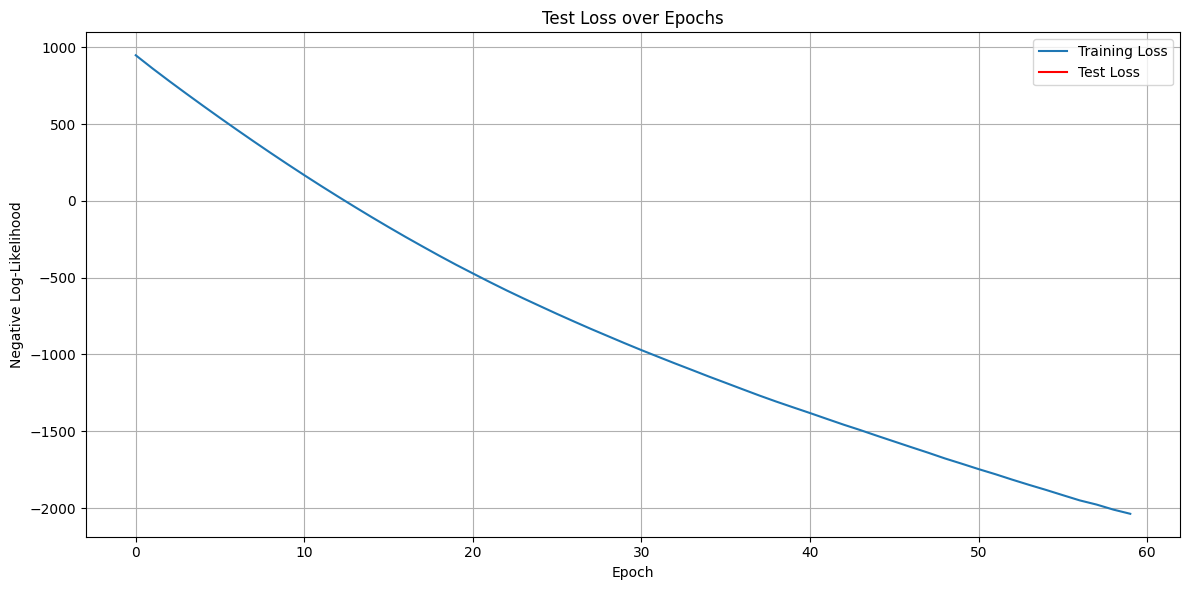

In [36]:
# Assuming train_losses and test_losses are lists containing the corresponding loss values for each epoch

# Plotting the training loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)

Test Loss: -663.2


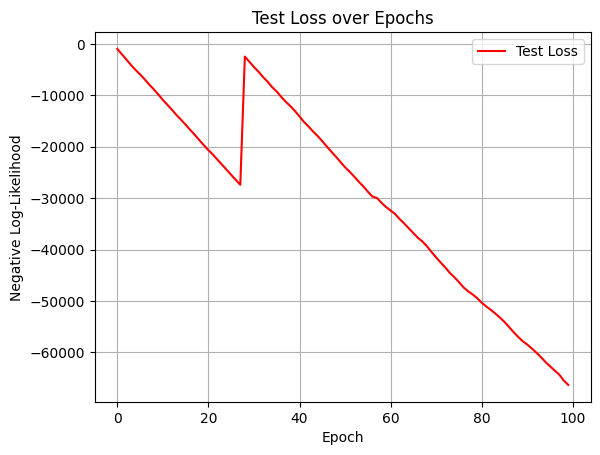

In [45]:
# Testing the RealNVP model
test_losses = test_realnvp(realnvp_model, test_loader)
# Plotting the test loss
plt.plot(test_losses, label='Test Loss', color='red')  # You can customize the color
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Test Loss over Epochs')
plt.legend()
plt.grid(True)

<ipython-input-33-c477f95014d7>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, i + 1)


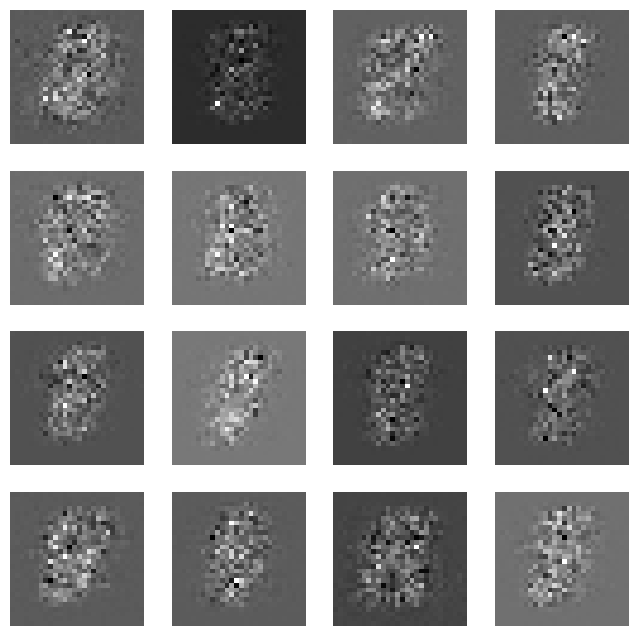

In [33]:
# Sample from the base distribution (multivariate normal)
base_distribution_samples = torch.distributions.MultivariateNormal(torch.zeros(input_size).to(device), torch.eye(input_size).to(device)).sample((16,))

# Use the inverse method to generate samples
generated_samples = realnvp_model.inverse(base_distribution_samples).view(16, 1, 28, 28)

# Plotting generated samples
plt.figure(figsize=(8, 8))
plt.title('16 random image from mnist')
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i, 0].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()
